##### Import Necessary Packages

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare, wilcoxon

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import wittgenstein as lw

##### Configuration

In [9]:
RESULTS_DIR = "../../temp_results/"
SAVE_DIR = "../../temp_results/grouped"

FOLDERS = ["AM", "MOEAAM", "MOEAAM_RS"]
OBJECTIVES = ["spec_sens"]

DATASETS = [
    "mushrooms", "tictactoe", "hepatitis", "ljubljana", "cargood", "chess",
    "zoo3", "flare", "yeast3", "segment0", "abalone19", "pageblocks"
]

TARGET_METRICS = [
    "accuracy", "f1_score", "recall", "precision", "specificity", 
    "nb_rules", "term_rule_ratio", "hypervolume"
]

##### Results Aggregation

In [10]:
def process_results():
    dataset_results = {}

    for dataset in DATASETS:
        mean_rows = []
        std_rows = []
        
        for folder in FOLDERS:
            for obj in OBJECTIVES:
                file_path = os.path.join(RESULTS_DIR, folder, f"{dataset}_{obj}.csv")
                
                if not os.path.exists(file_path):
                    continue
                
                try:
                    df = pd.read_csv(file_path)
                    
                    # Normalization
                    if 'accuracy' in df.columns and df['accuracy'].dropna().max() <= 1.0001:
                        cols_to_scale = ["accuracy", "f1_score", "recall", "precision", "specificity"]
                        for col in cols_to_scale:
                            if col in df.columns:
                                df[col] = df[col] * 100
                    
                    # Mean and Std grouped by Split
                    numeric_cols = df.select_dtypes(include='number').columns
                    means_by_split = df.groupby('split')[numeric_cols].mean().round(3)
                    stds_by_split = df.groupby('split')[numeric_cols].std().round(3)
                    
                    
                    for split in ['train', 'test']:
                        if split in means_by_split.index:
                            
                            
                            base_info = {
                                "Algorithm": folder,
                                "Objective": obj,
                                "Split": split
                            }
                            
                            row_mean = base_info.copy()
                            row_std = base_info.copy()
                            
                            for metric in TARGET_METRICS:
                                if metric in means_by_split.columns:
                                    row_mean[metric] = means_by_split.loc[split, metric]
                                else:
                                    row_mean[metric] = None
                                
                                if metric in stds_by_split.columns:
                                    row_std[metric] = stds_by_split.loc[split, metric]
                                else:
                                    row_std[metric] = None
                            
                            mean_rows.append(row_mean)
                            std_rows.append(row_std)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # Create DataFrames
        dataset_results[dataset] = {}
        
        if mean_rows:
            # Mean DataFrame
            df_mean = pd.DataFrame(mean_rows)
            df_mean.set_index(["Algorithm", "Objective", "Split"], inplace=True)
            dataset_results[dataset]['mean'] = df_mean
            
            # Std DataFrame
            df_std = pd.DataFrame(std_rows)
            df_std.set_index(["Algorithm", "Objective", "Split"], inplace=True)
            dataset_results[dataset]['std'] = df_std
        else:
            dataset_results[dataset]['mean'] = pd.DataFrame()
            dataset_results[dataset]['std'] = pd.DataFrame()

    return dataset_results

dfs = process_results()

In [11]:
for dataset, df in dfs.items():
    df['mean'].to_csv(os.path.join(SAVE_DIR, f"{dataset}_mean.csv"))
    df['std'].to_csv(os.path.join(SAVE_DIR, f"{dataset}_std.csv"))

##### Generalization 

In [12]:
sns.set_theme(style="whitegrid")

def plot_generalization_gap(results, datasets, metric="f1_score"):

    # Configuration
    colors = {'train': '#1f77b4', 'test': '#d62728', 'line': '#7f7f7f'}
    obj_map = {
        "spec_sens": "sp,se", "conf_simp": "conf,si", 
        "conf_spec": "conf,sp", "conf_sens": "conf,se"
    }
    
    fig, axes = plt.subplots(4, 3, figsize=(26, 20))
    axes_flat = axes.flatten()

    for i, ax in enumerate(axes_flat):
        if i >= len(datasets):
            ax.axis('off')
            continue
            
        ds_name = datasets[i]
        
        if ds_name not in results or 'mean' not in results[ds_name]:
            continue

        df = results[ds_name]['mean'].reset_index().copy()
        
        if metric not in df.columns:
            continue

        df['Label'] = df.apply(
            lambda x: f"{x['Algorithm']} ({obj_map.get(x['Objective'], x['Objective'])})", 
            axis=1
        )
        
        df_viz = df.pivot(index='Label', columns='Split', values=metric)
        if 'test' in df_viz.columns:
            df_viz = df_viz.sort_values(by='test', ascending=True)

        ax.hlines(y=df_viz.index, xmin=df_viz['test'], xmax=df_viz['train'], 
                  color=colors['line'], alpha=0.5, linewidth=3, zorder=1)
        
        ax.scatter(df_viz['train'], df_viz.index, color=colors['train'], s=80, zorder=2, label='Train' if i == 0 else "")
        ax.scatter(df_viz['test'], df_viz.index, color=colors['test'], s=80, zorder=2, label='Test' if i == 0 else "")

        for idx, label in enumerate(df_viz.index):
            train_val = df_viz.loc[label, 'train']
            test_val = df_viz.loc[label, 'test']
            
            ax.text(train_val, idx + 0.15, f"{train_val:.1f}", 
                    ha='center', va='bottom', fontsize=9, color=colors['train'], fontweight='bold')

            is_close = abs(train_val - test_val) < 2.0
            test_va = 'top' if is_close else 'bottom'
            test_offset = -0.15 if is_close else 0.15

            ax.text(test_val, idx + test_offset, f"{test_val:.1f}", 
                    ha='center', va=test_va, fontsize=9, color=colors['test'], fontweight='bold')

        ax.set_title(ds_name.capitalize(), fontsize=12, fontweight='bold')
        ax.tick_params(axis='y', labelsize=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xlim(0, 103)

    handles, labels = axes_flat[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 0.99))

    fig.suptitle(f"Generalization Gap ({metric.replace('_', ' ').capitalize()})", fontsize=18, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

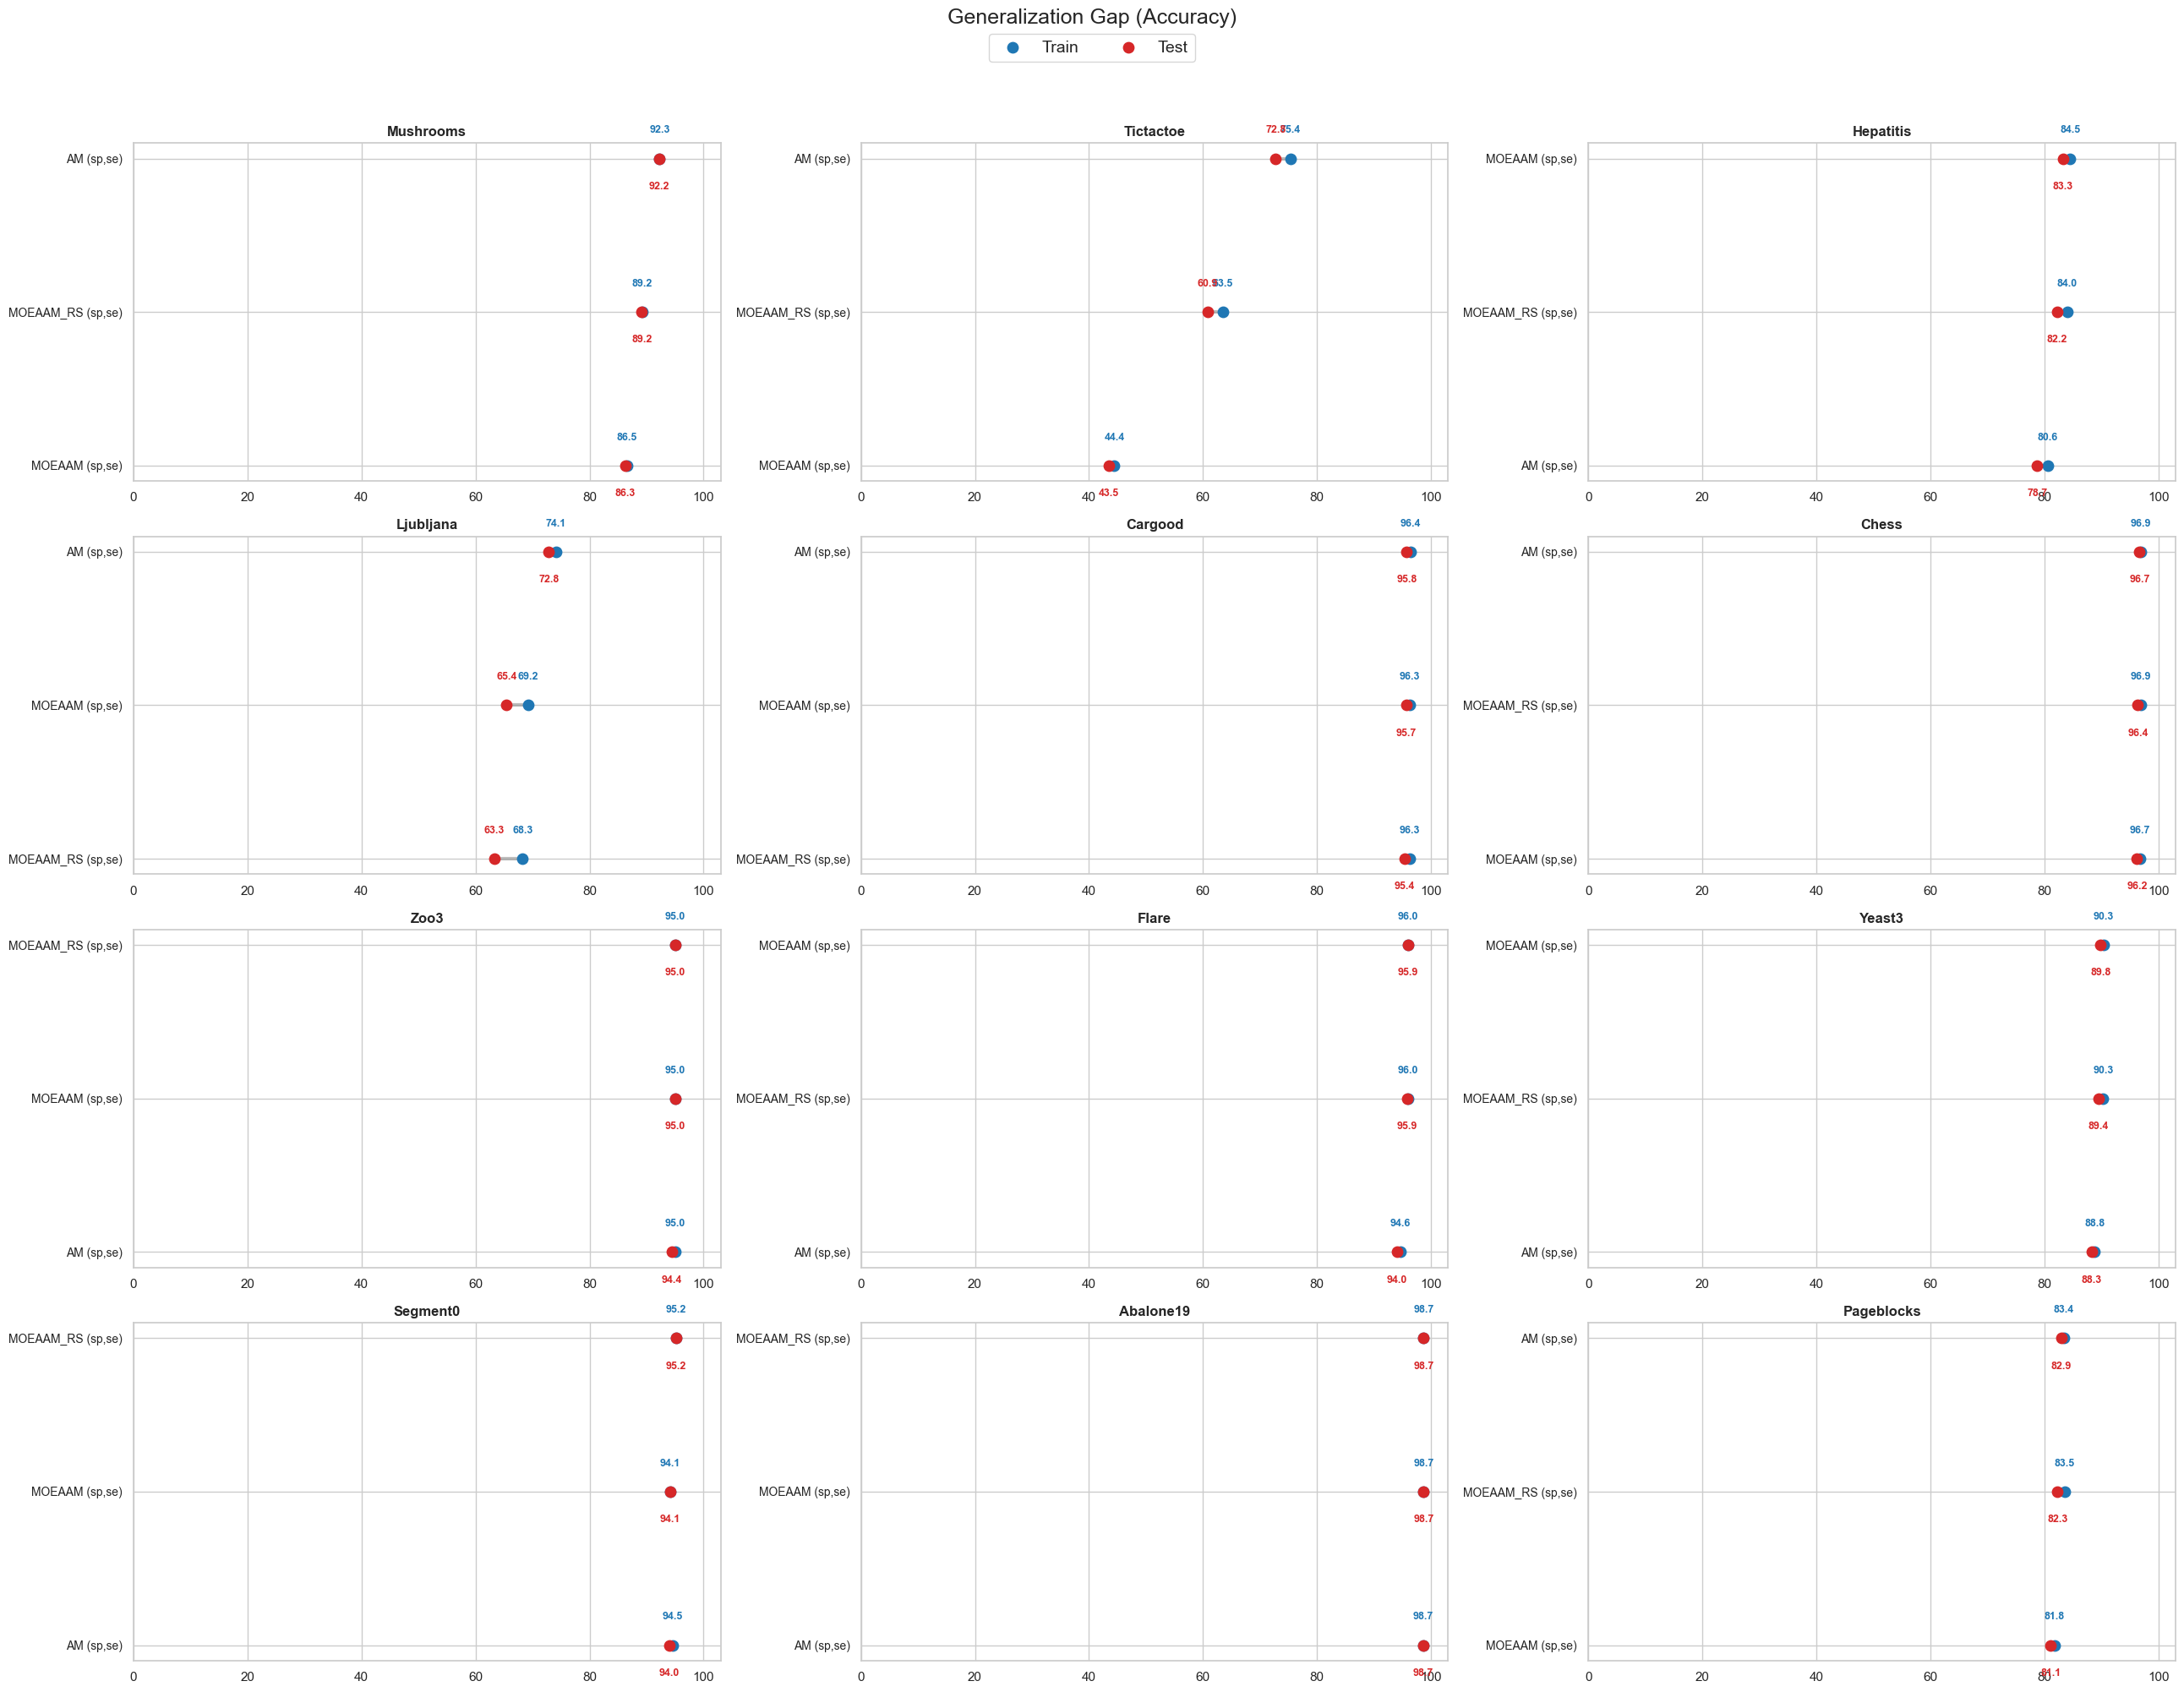

In [13]:
plot_generalization_gap(dfs, DATASETS, metric="accuracy")

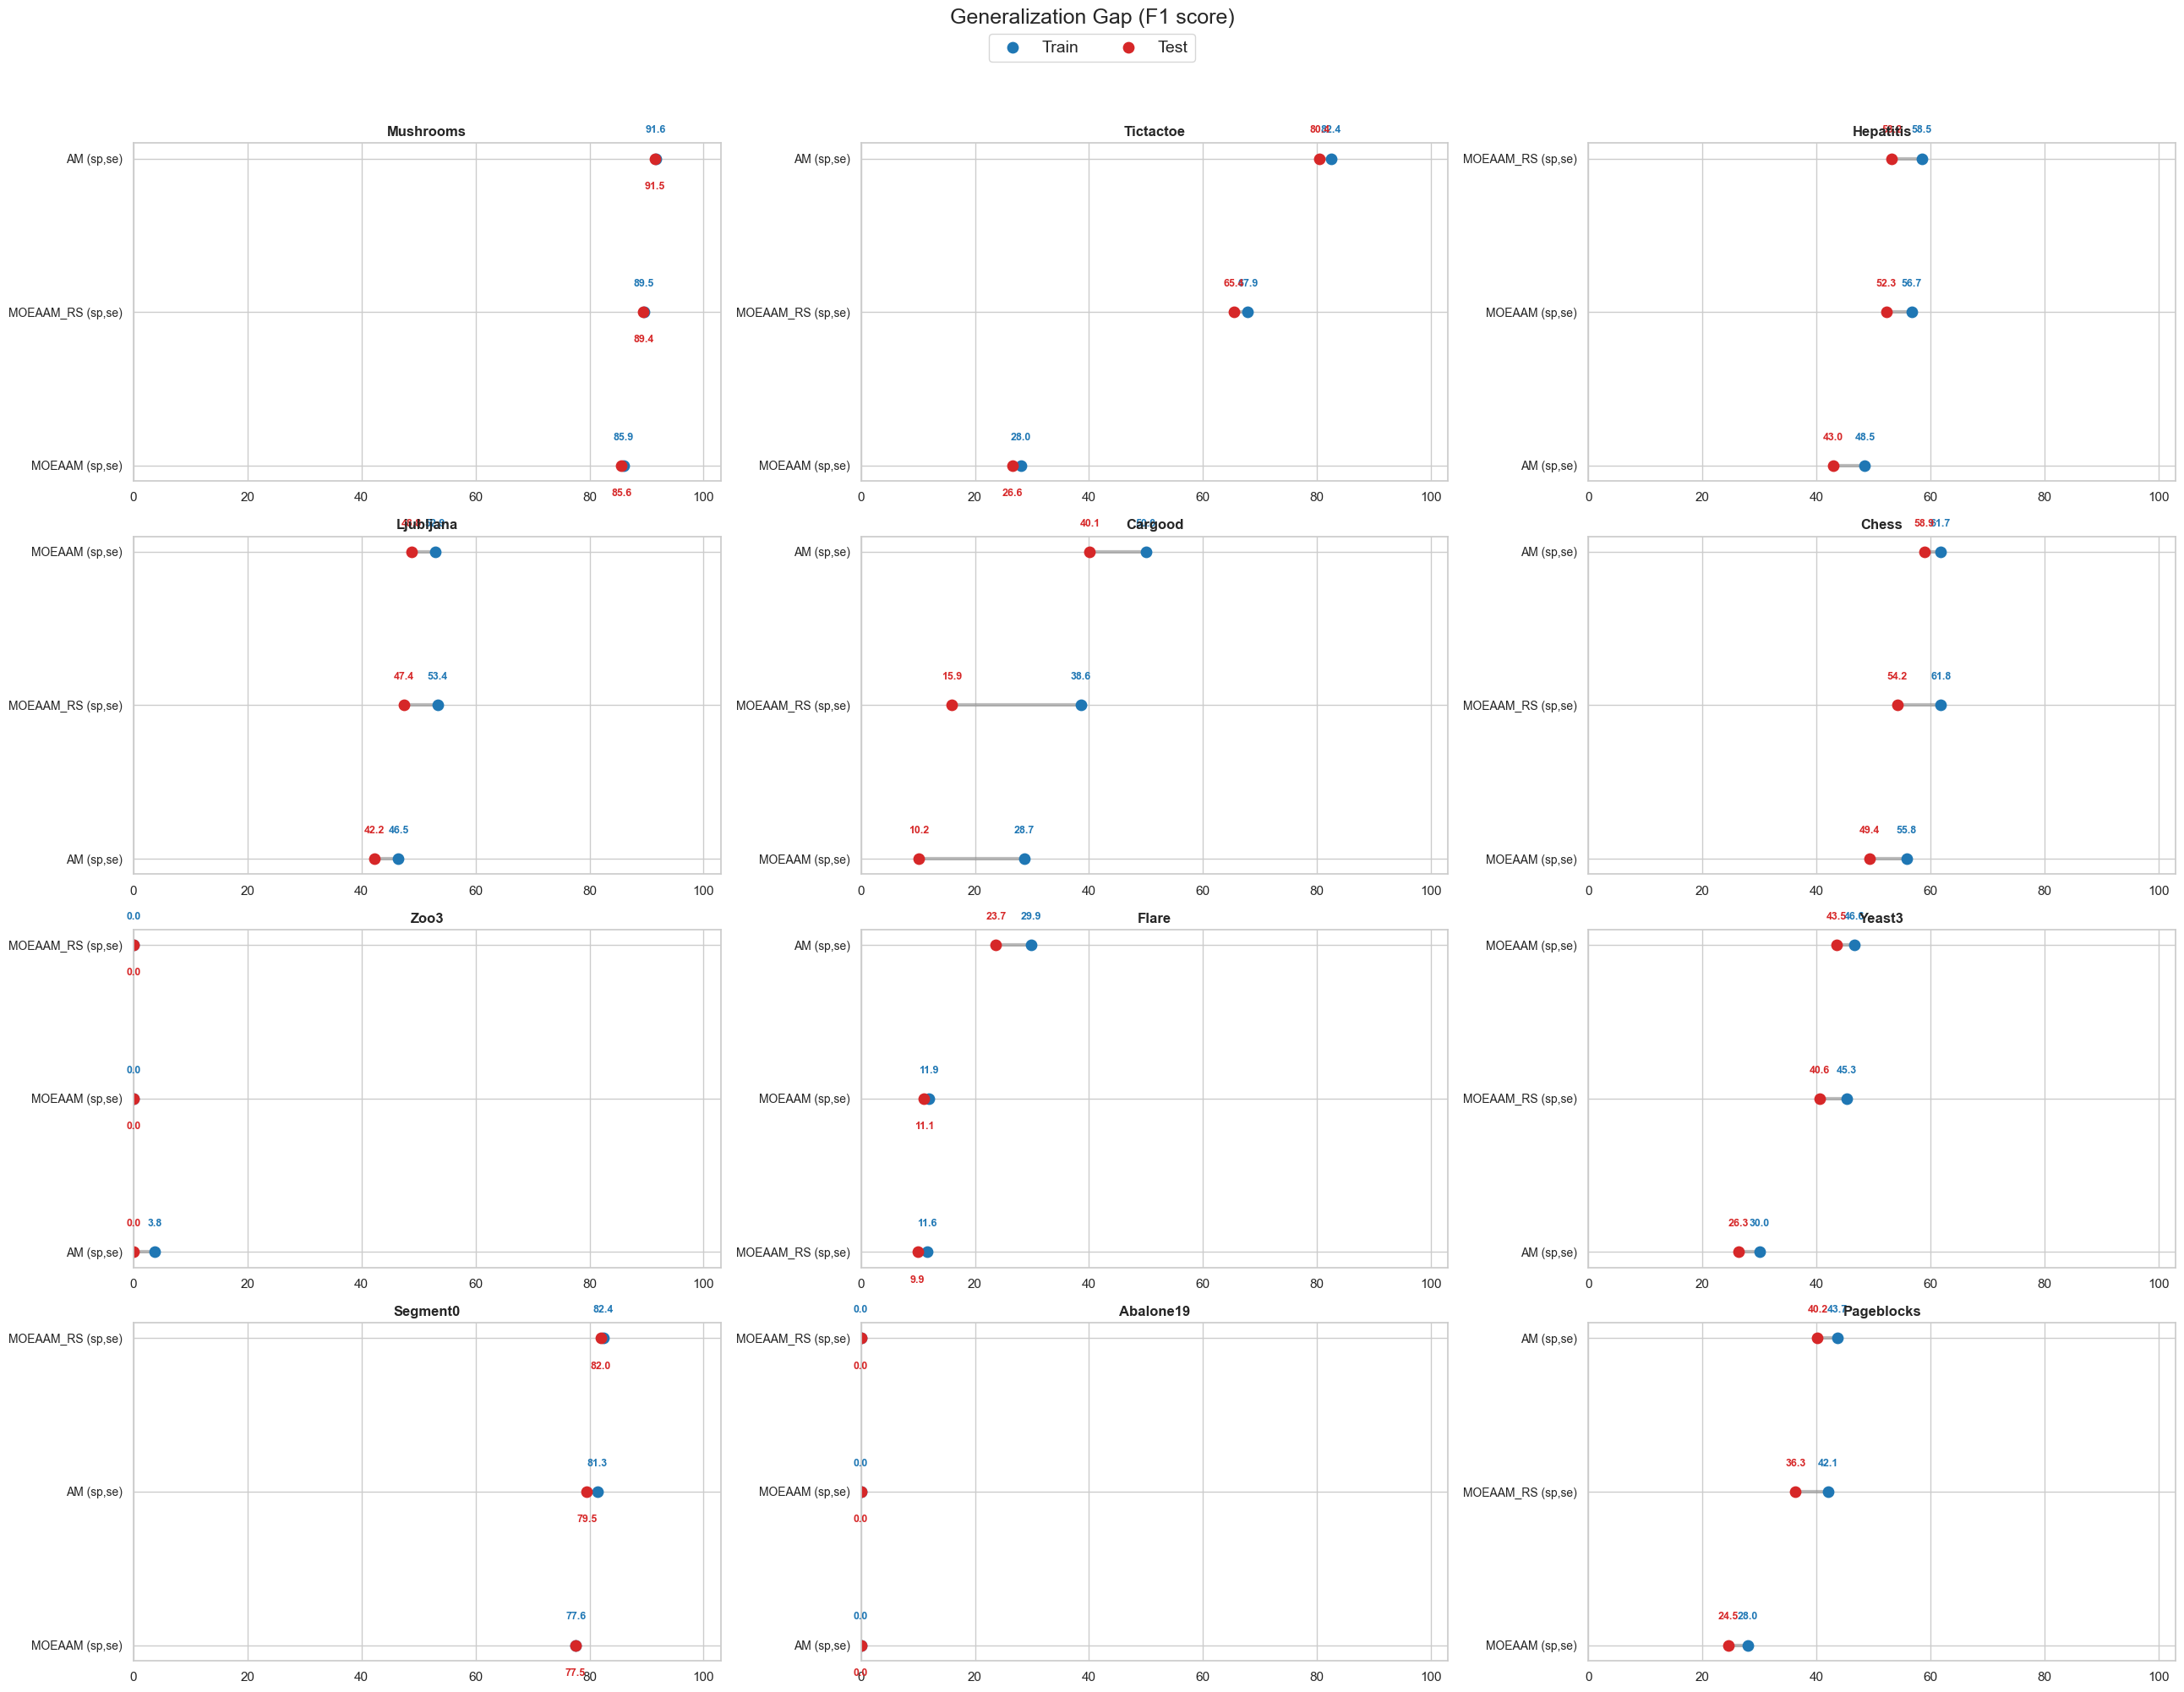

In [14]:
plot_generalization_gap(dfs, DATASETS, metric="f1_score")

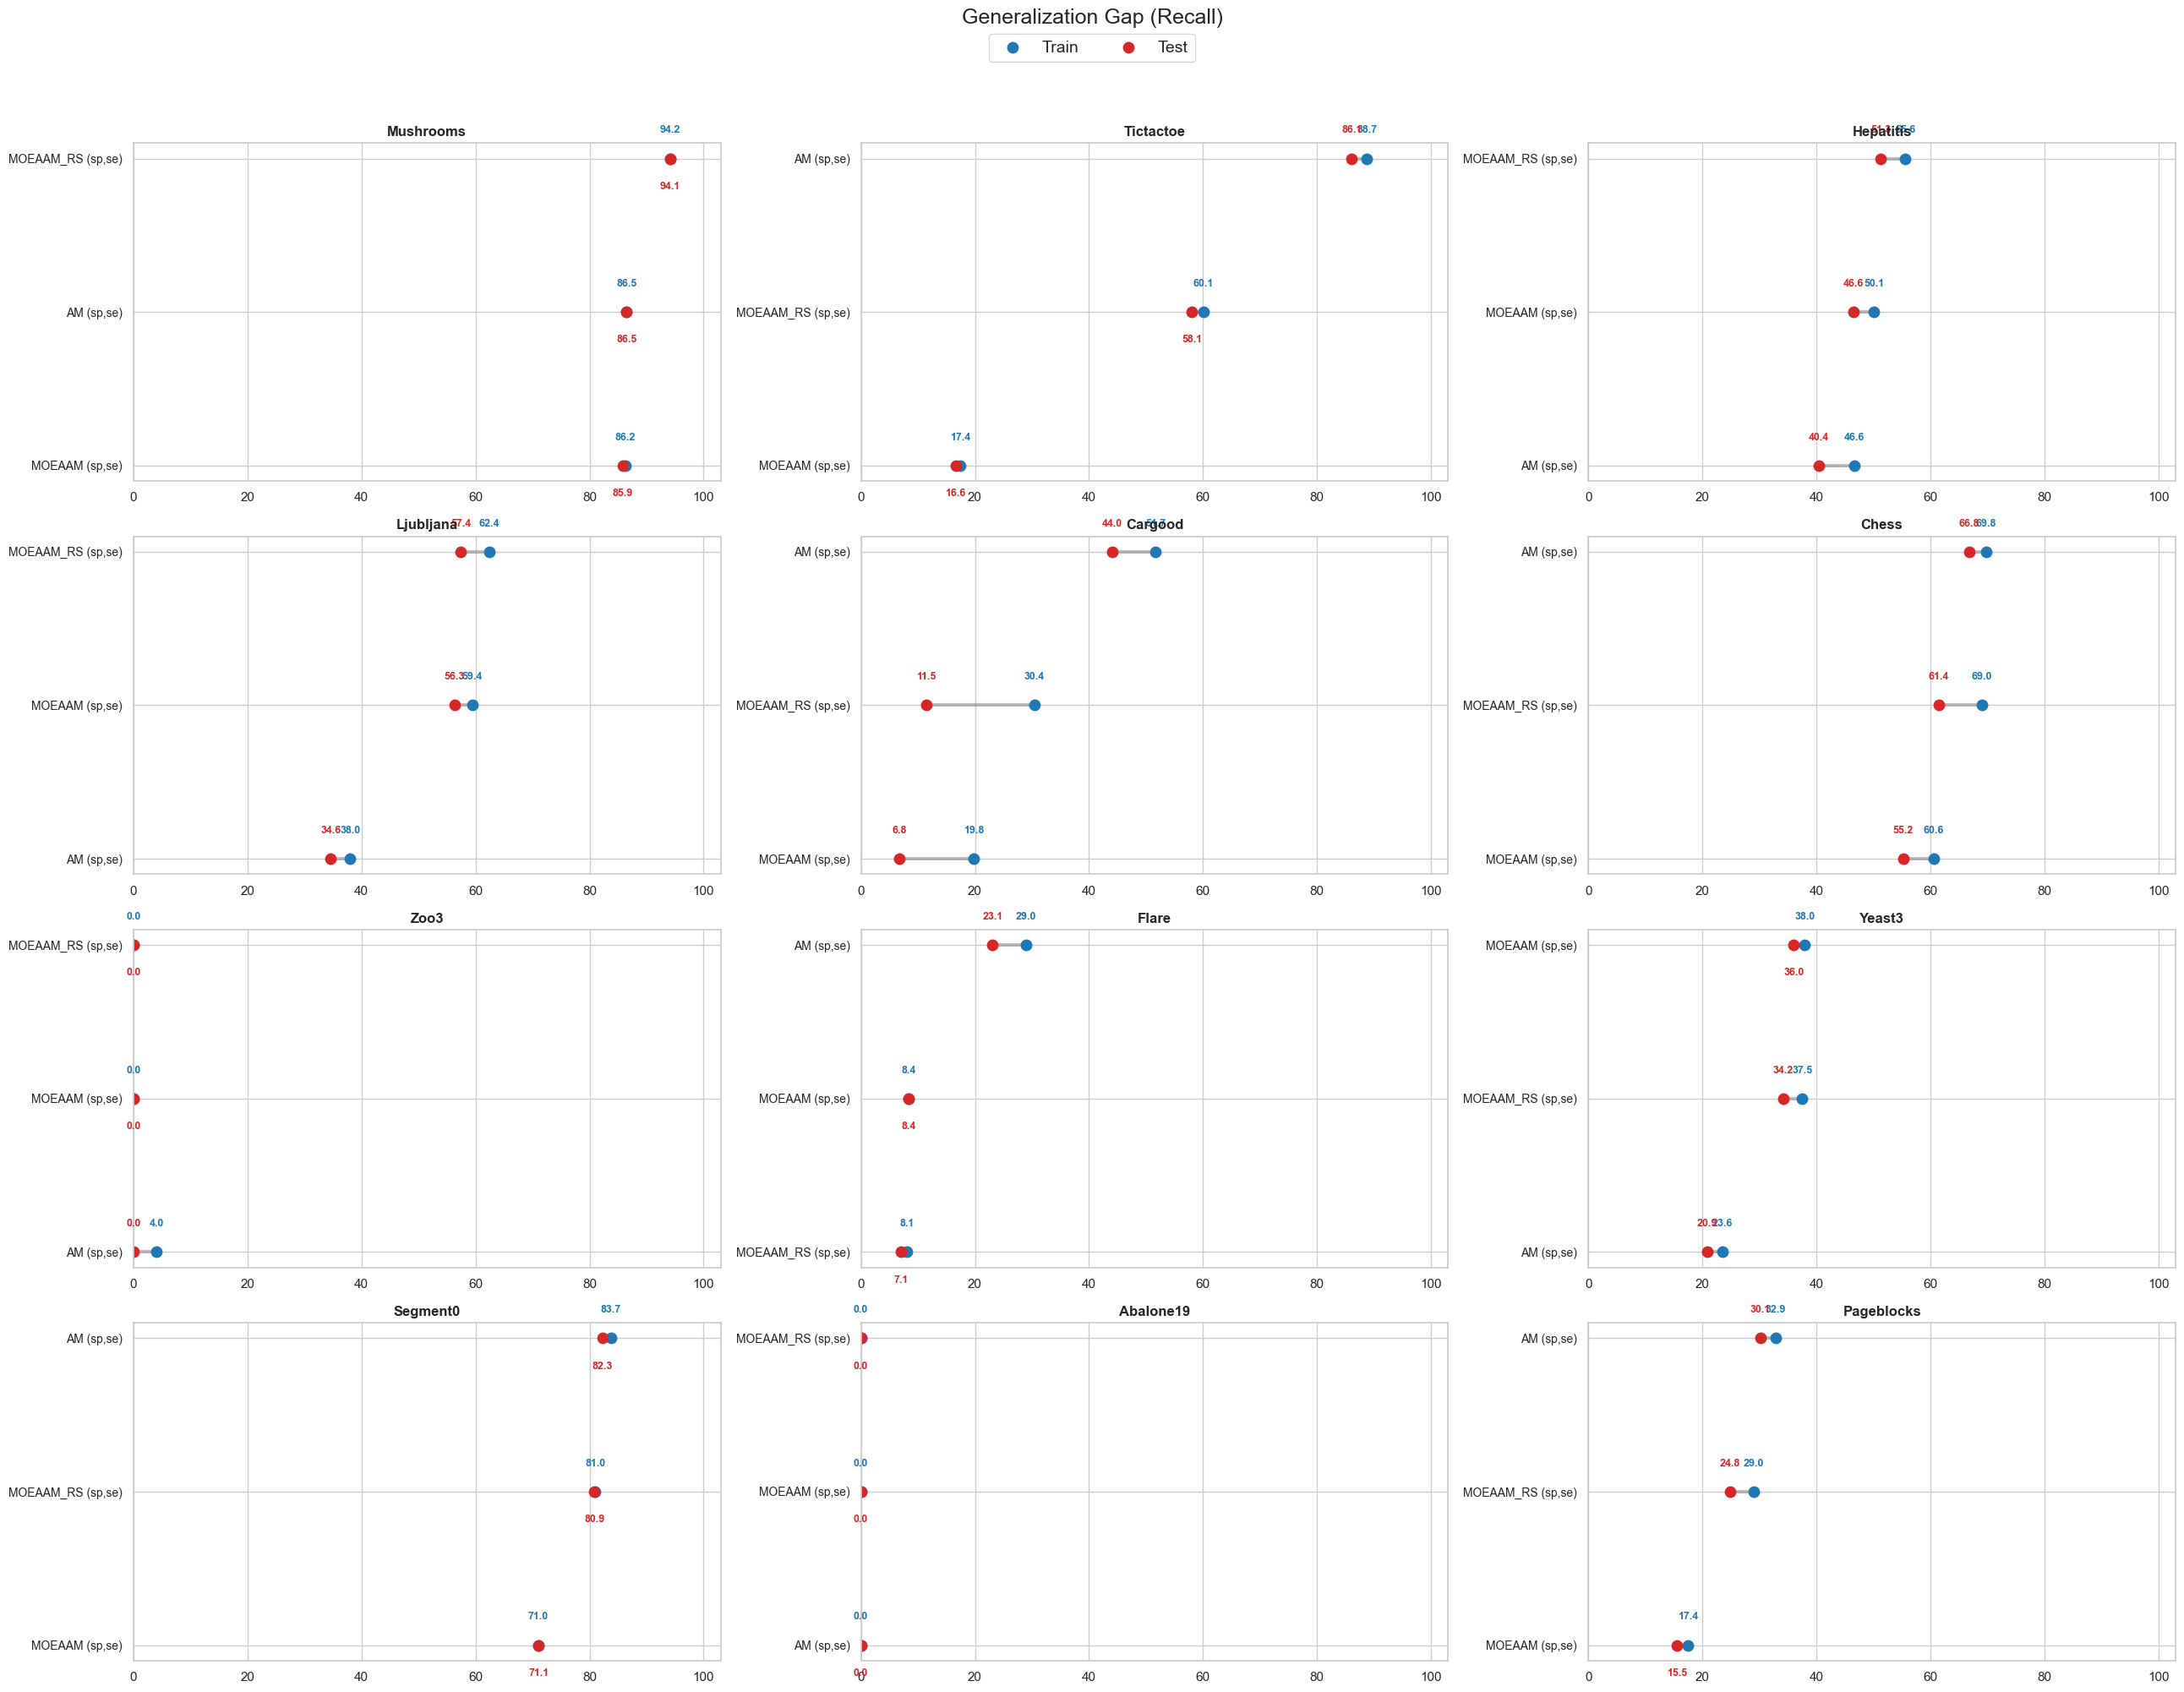

In [15]:
plot_generalization_gap(dfs, DATASETS, metric="recall")

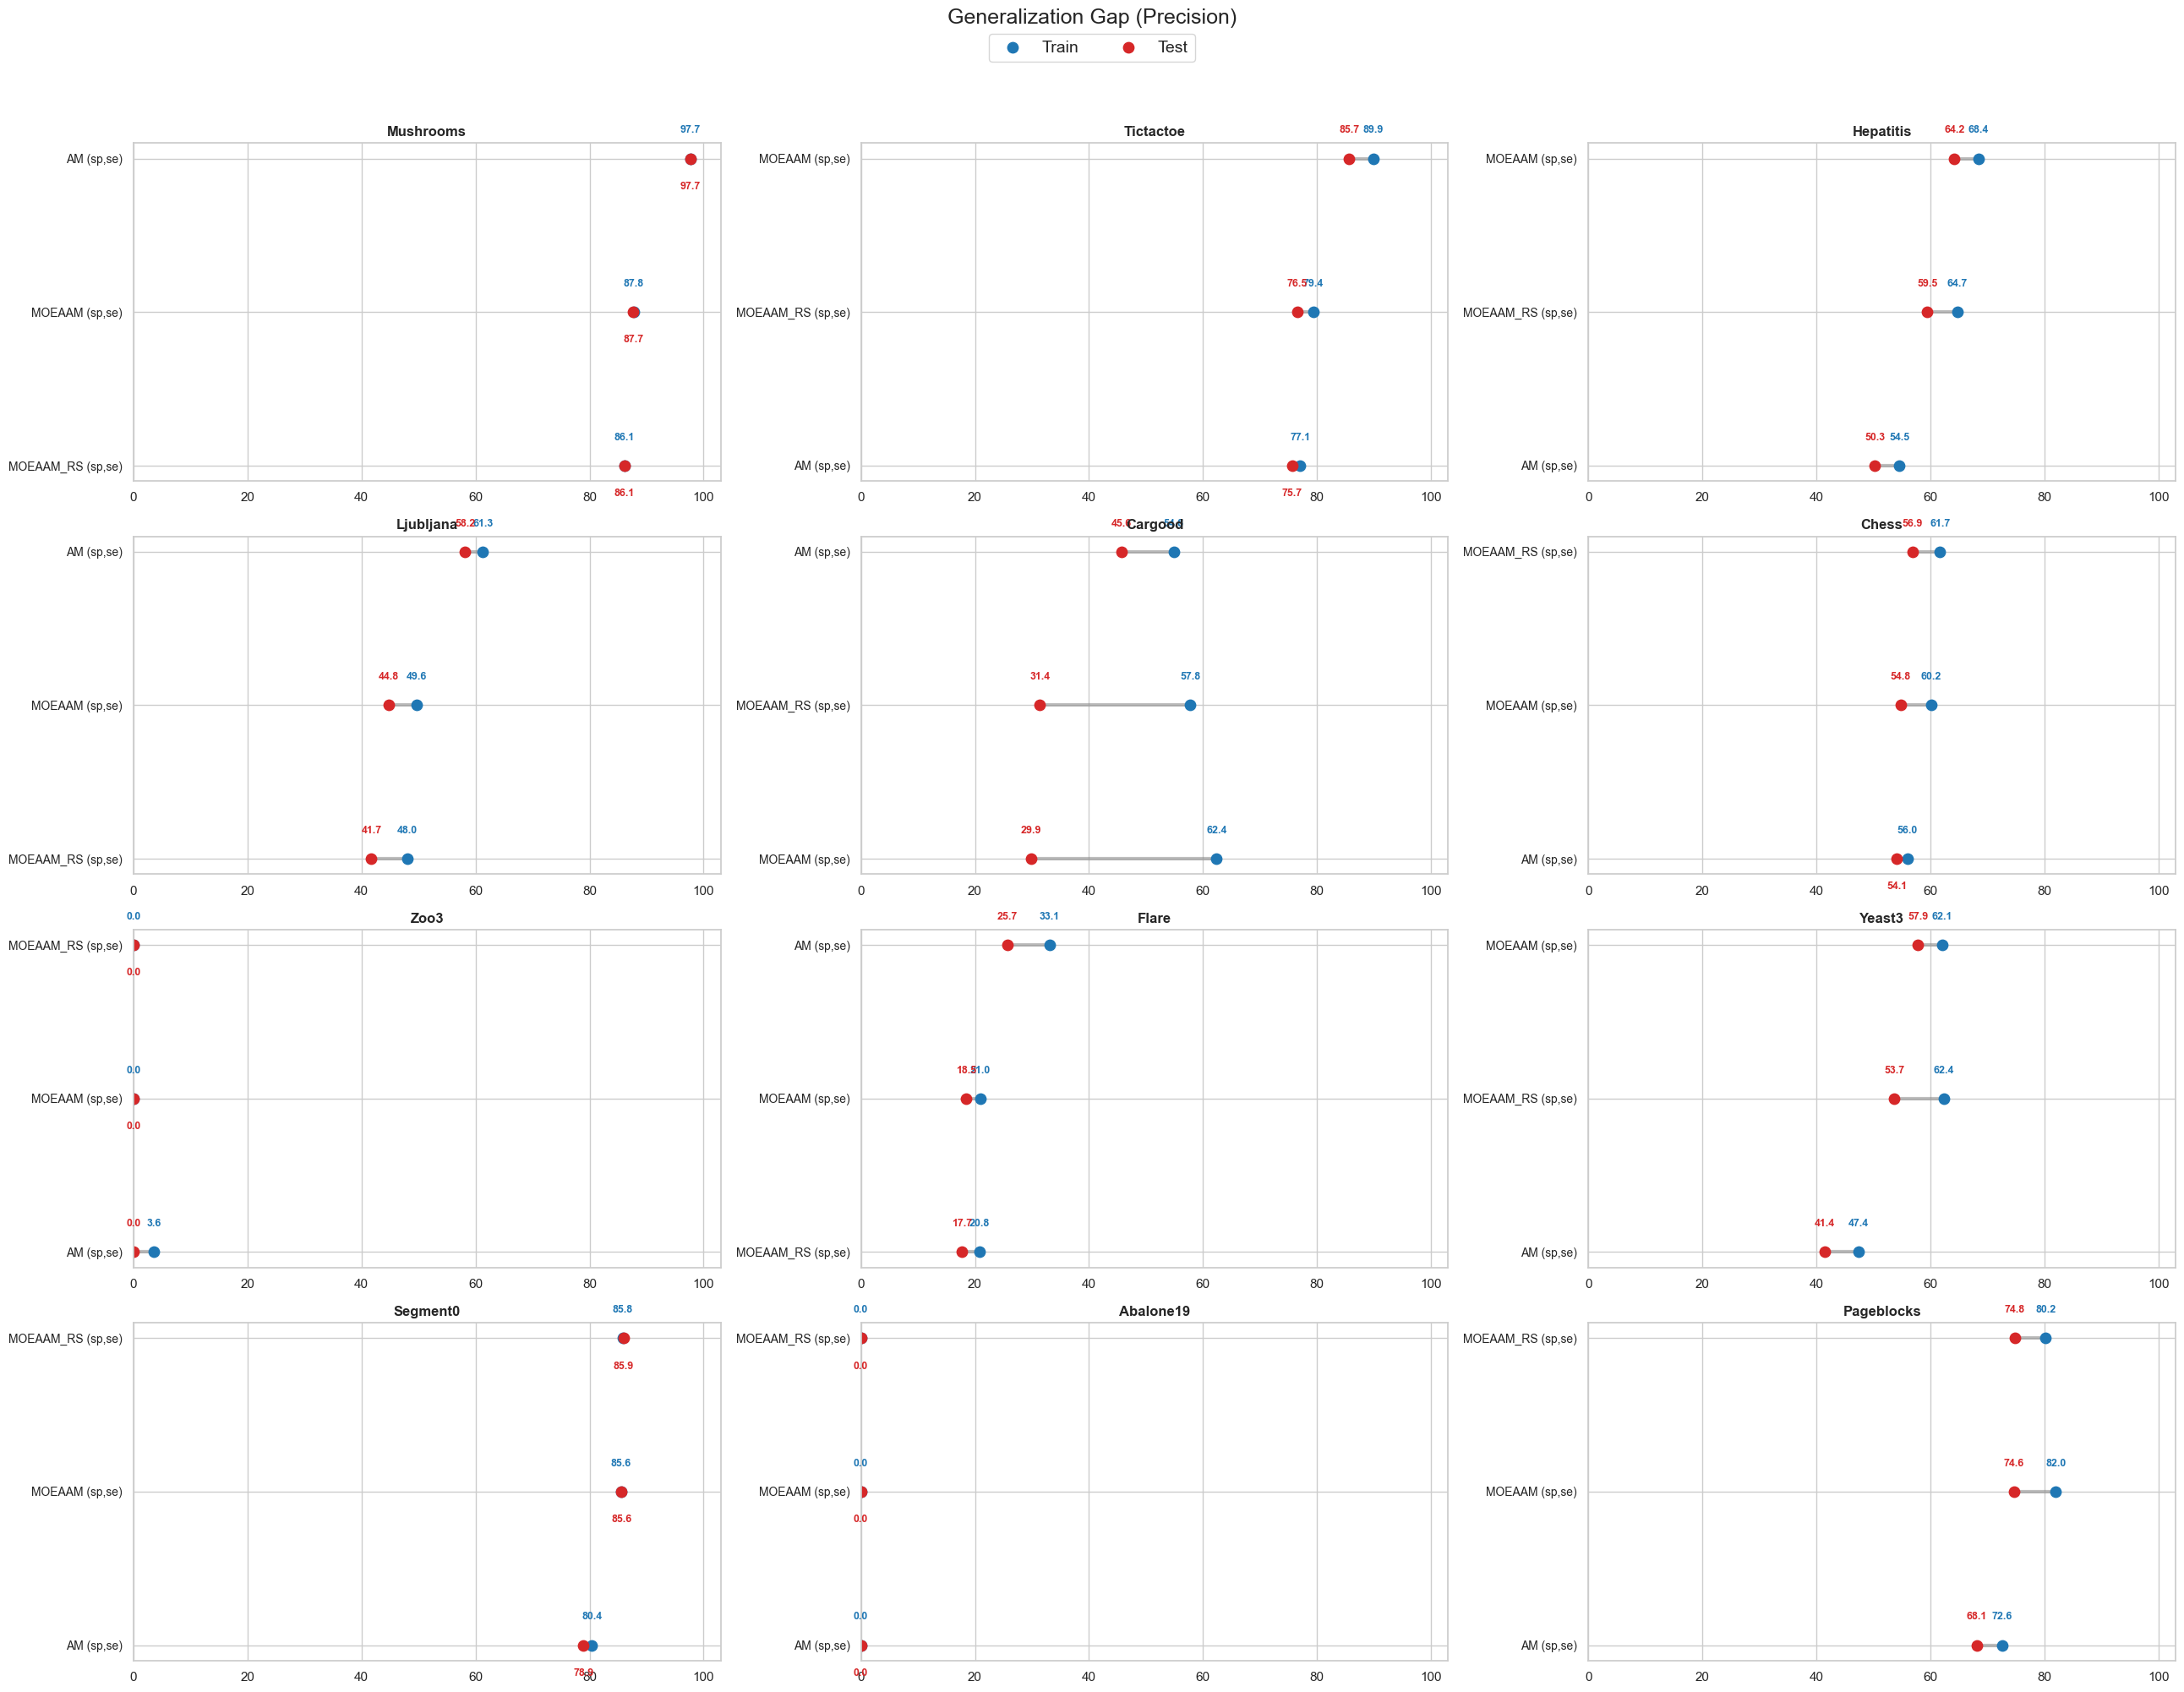

In [16]:
plot_generalization_gap(dfs, DATASETS, metric="precision")

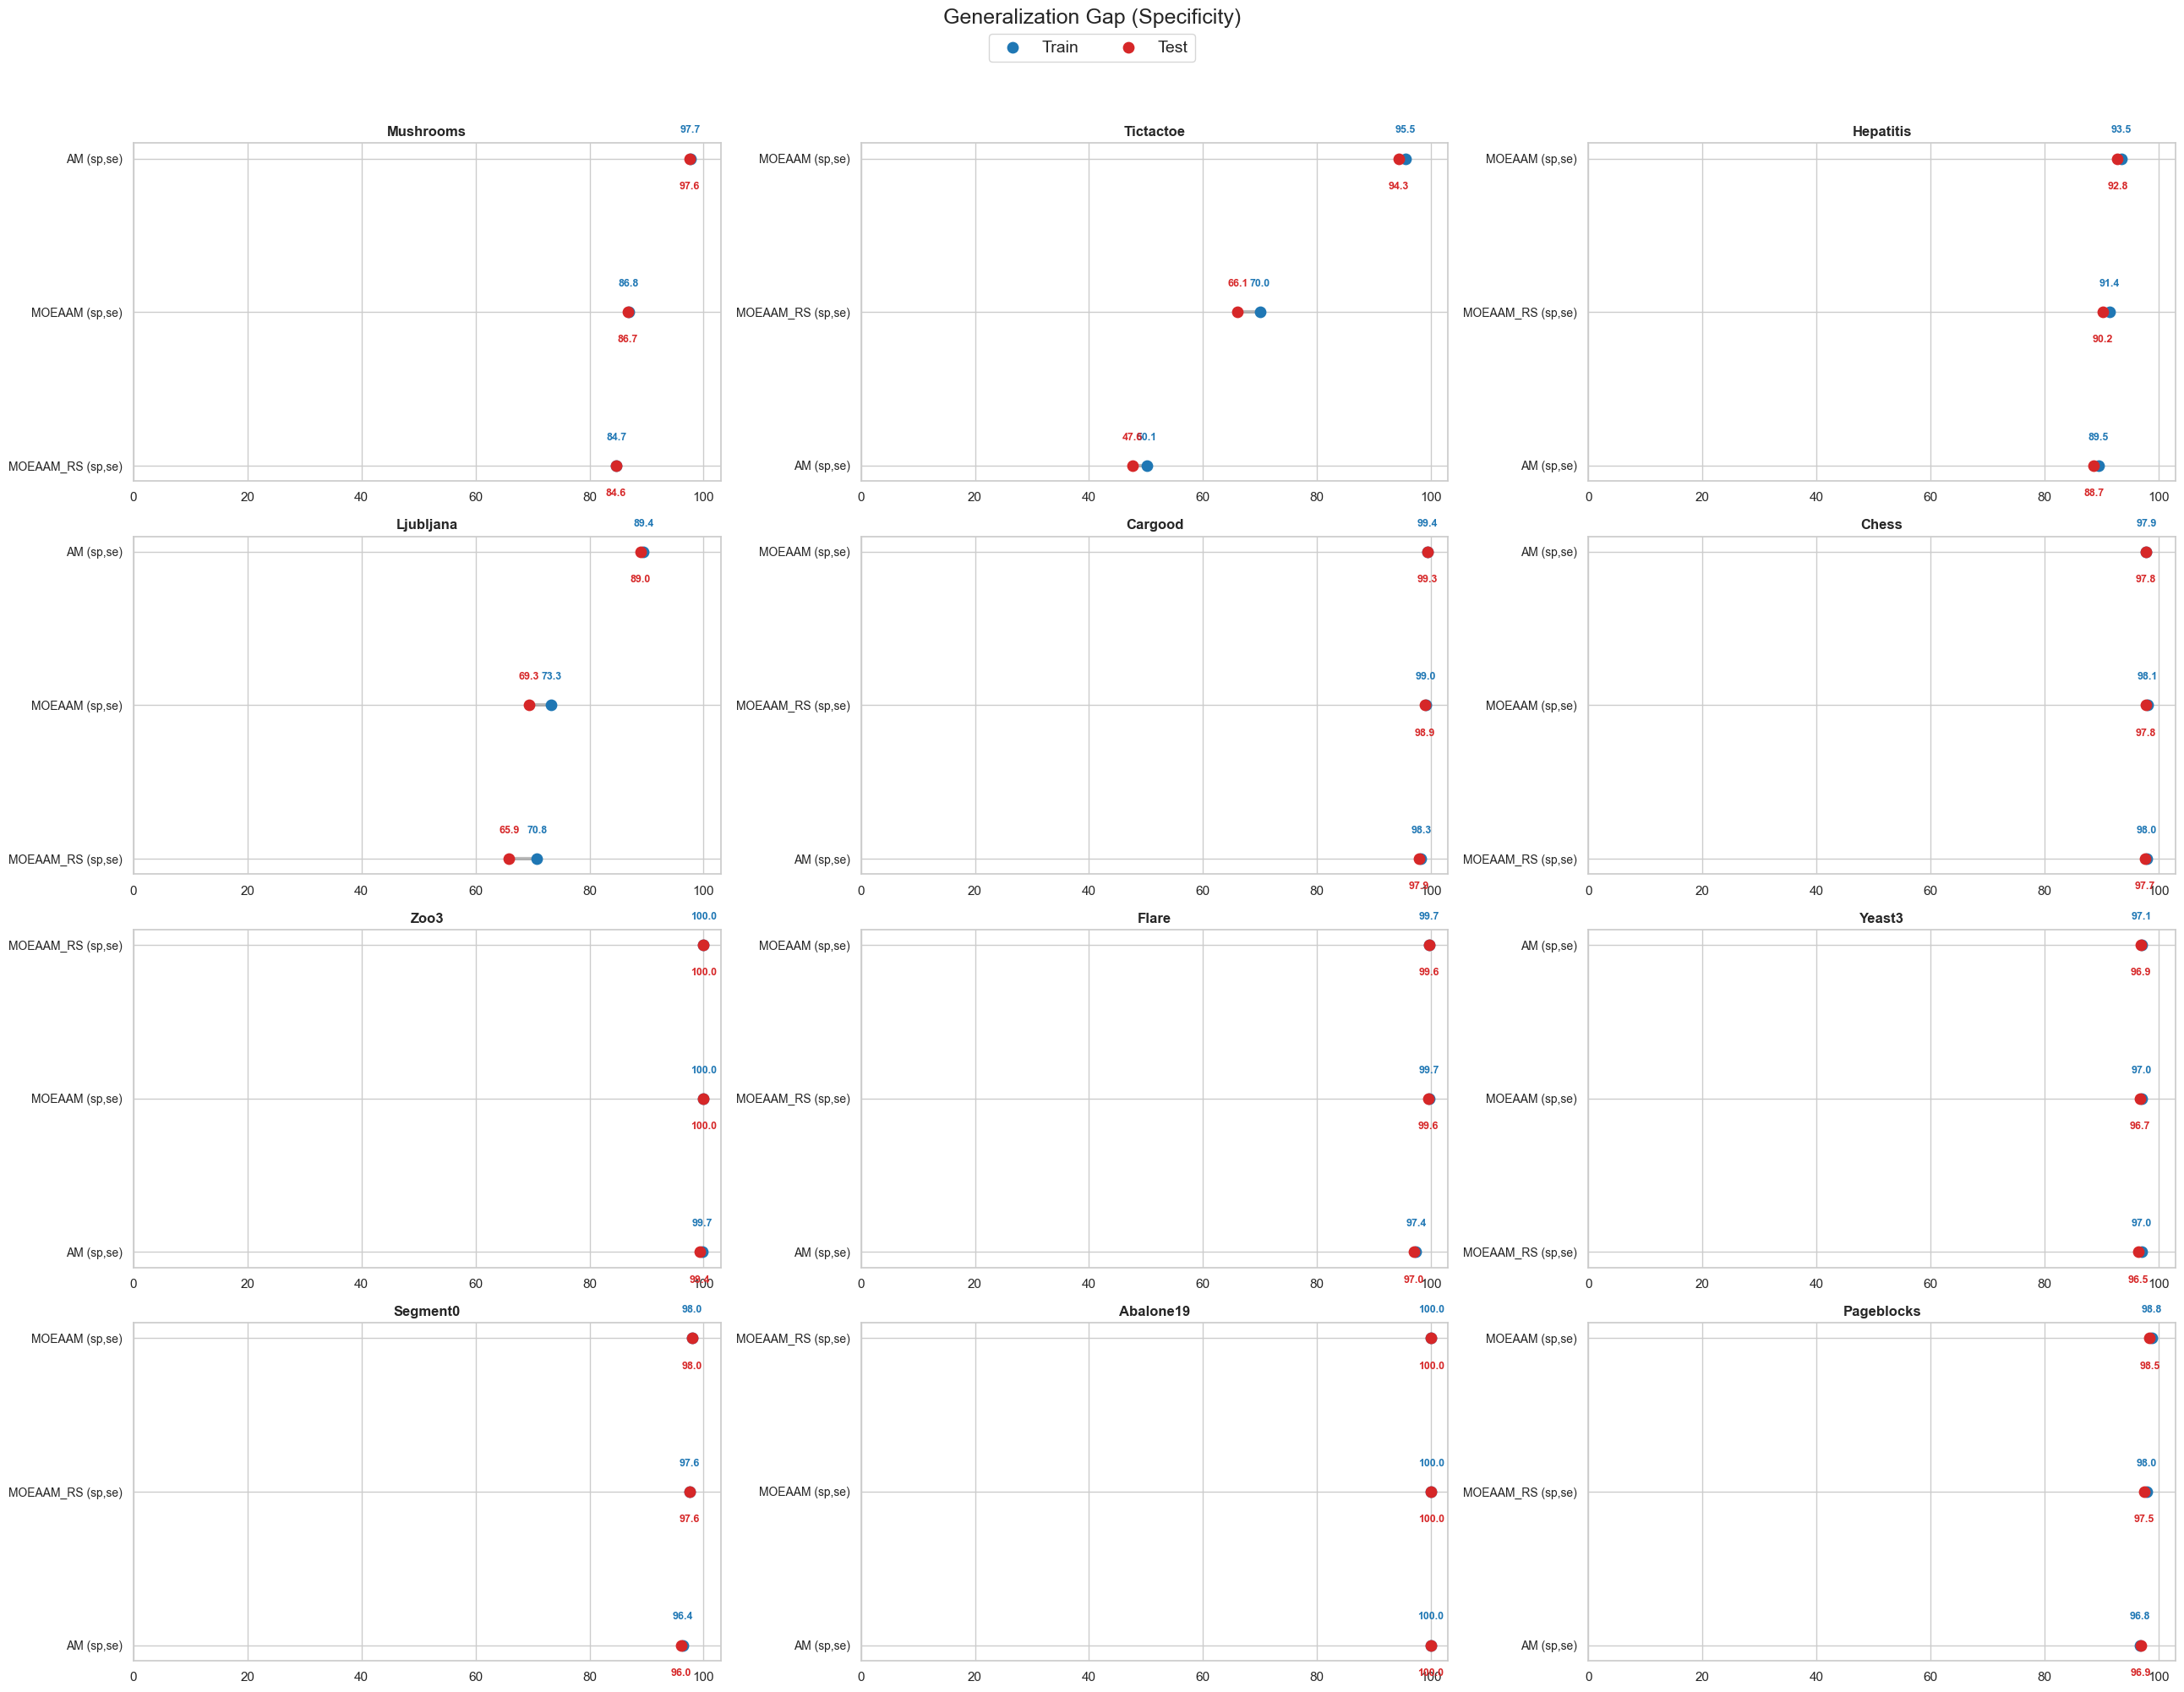

In [17]:
plot_generalization_gap(dfs, DATASETS, metric="specificity")

##### Results Ranking

In [20]:
def get_ranking_df(df_values):

    df_ranks = df_values.rank(axis=1, ascending=False, method='average')
    avg_ranks = df_ranks.mean(axis=0)
    df_ranks.loc['Average Rank'] = avg_ranks
    df_ranks= df_ranks.map(lambda x: f'{x:g}')
    
    return df_ranks

def get_ranking(df_values):
    ranks = df_values.rank(axis=1, ascending=False, method='average')
    df_out = df_values.map('{:g}'.format) + " (" + ranks.map('{:g}'.format) + ")"
    df_out.loc['Average Rank'] = ranks.mean().map('{:.4g}'.format)

    return df_out, ranks.mean()

def plot_avg_ranks(avg_ranks, metric_name):
    sorted_avg_ranks = avg_ranks.sort_values()
    plt.figure(figsize=(12, 6))
    sorted_avg_ranks.plot(kind='barh', color='lightgrey')
    plt.title(f'Average Rank of Each Variant for {metric_name}')
    plt.xlabel('Mean Rank')
    
    plt.axvline(x=sorted_avg_ranks.mean(), color='red', linestyle='--', label='Global Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
def extract_means(results_data, target_metric="accuracy"):
    friedman_dict = {}

    for folder in FOLDERS:
        for obj in OBJECTIVES:
            
            dict_key = f"{folder}({obj})"    
            scores_list = []
            
            for dataset in DATASETS:
                if dataset not in results_data or 'mean' not in results_data[dataset]:
                    scores_list.append(None)
                    continue
                
                df_mean = results_data[dataset]['mean']
                
                if df_mean.empty:
                    scores_list.append(None)
                    continue
                
                try:
                    val = df_mean.loc[(folder, obj, 'test'), target_metric]
                    scores_list.append(round(val, 2))
                    
                except KeyError:
                    scores_list.append(None)
            
            friedman_dict[dict_key] = scores_list

    return friedman_dict

def extract_specific_means(results_data, combinations, target_metric="accuracy"):
    friedman_dict = {}

    for algo, obj in combinations:
        
        dict_key = f"{algo}({obj})"
        scores_list = []
        
        for dataset in DATASETS:
            if dataset not in results_data or 'mean' not in results_data[dataset]:
                scores_list.append(None)
                continue
            
            df_mean = results_data[dataset]['mean']
            
            if df_mean.empty:
                scores_list.append(None)
                continue
            
            try:
                val = df_mean.loc[(algo, obj, 'test'), target_metric]
                scores_list.append(round(val, 2))
                
            except KeyError:
                scores_list.append(None)
        
        friedman_dict[dict_key] = scores_list

    return friedman_dict

1. ACCURACY

In [22]:
accuracy_dict = extract_means(dfs, target_metric="accuracy")

accuracy_df = pd.DataFrame(accuracy_dict, index=DATASETS)
accuracy_ranks, accuracy_avg_ranks = get_ranking(accuracy_df)
accuracy_ranks

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,92.22 (1),86.29 (3),89.18 (2)
tictactoe,72.78 (1),43.53 (3),60.85 (2)
hepatitis,78.71 (3),83.29 (1),82.19 (2)
ljubljana,72.83 (1),65.44 (2),63.31 (3)
cargood,95.75 (1),95.65 (2),95.39 (3)
chess,96.67 (1),96.24 (3),96.38 (2)
zoo3,94.45 (3),95.05 (1.5),95.05 (1.5)
flare,94.02 (3),95.95 (1),95.85 (2)
yeast3,88.3 (3),89.85 (1),89.44 (2)
segment0,94.03 (3),94.1 (2),95.2 (1)


In [50]:
rule_dict = extract_means(dfs, target_metric="nb_rules")

rule_df = pd.DataFrame(rule_dict, index=DATASETS)
rule_df, rule_avg_ranks = get_ranking(rule_df)
rule_df

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,12.94 (2),3.24 (3),13.36 (1)
tictactoe,34.88 (2),4.14 (3),35.56 (1)
hepatitis,344.1 (1),4.7 (3),74.88 (2)
ljubljana,40.12 (2),5.16 (3),60.98 (1)
cargood,11.76 (1),1.74 (3),3.74 (2)
chess,16.26 (1),3.6 (3),7.34 (2)
zoo3,10.28 (1),0 (2.5),0 (2.5)
flare,13.1 (1),0.5 (3),0.56 (2)
yeast3,102.22 (1),2.06 (3),4.9 (2)
segment0,45 (1),2.14 (3),17.1 (2)


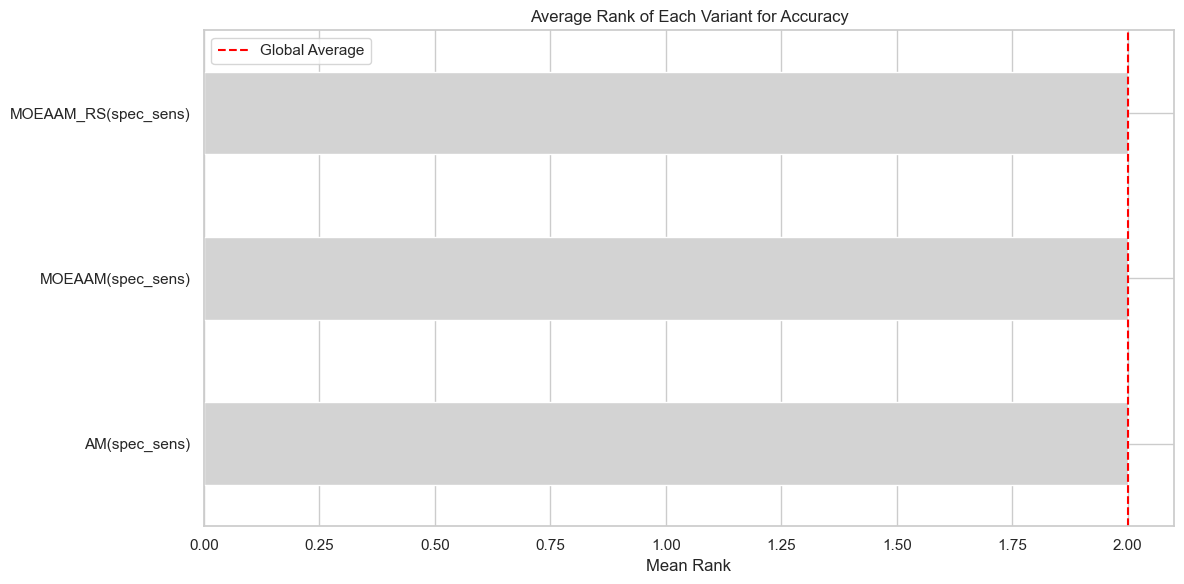

In [23]:
plot_avg_ranks(accuracy_avg_ranks, "Accuracy")

2. F1-SCORE

In [24]:
f1_dict = extract_means(dfs, target_metric="f1_score")

f1_df = pd.DataFrame(f1_dict, index=DATASETS)
f1_ranks, f1_avg_ranks = get_ranking(f1_df)
f1_ranks

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,91.5 (1),85.62 (3),89.44 (2)
tictactoe,80.43 (1),26.56 (3),65.43 (2)
hepatitis,42.96 (3),52.3 (2),53.2 (1)
ljubljana,42.19 (3),48.77 (1),47.38 (2)
cargood,40.15 (1),10.19 (3),15.93 (2)
chess,58.92 (1),49.38 (3),54.22 (2)
zoo3,0 (2),0 (2),0 (2)
flare,23.7 (1),11.07 (2),9.92 (3)
yeast3,26.33 (3),43.54 (1),40.62 (2)
segment0,79.54 (2),77.55 (3),82 (1)


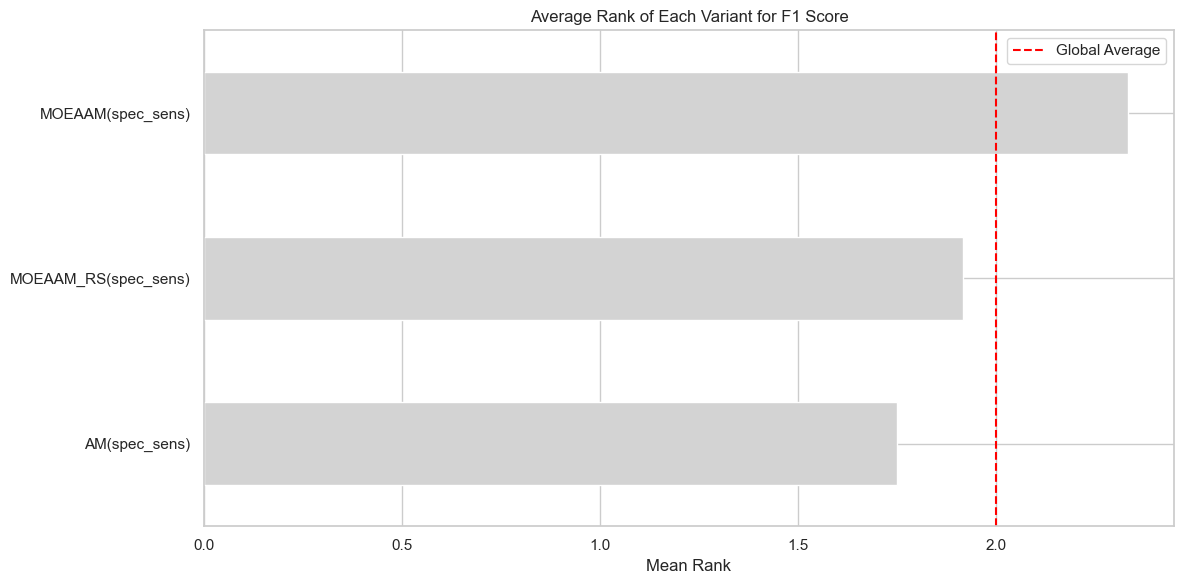

In [25]:
plot_avg_ranks(f1_avg_ranks, "F1 Score")

3. RECALL

In [26]:
recall_dict = extract_means(dfs, target_metric="recall")

recall_df = pd.DataFrame(recall_dict, index=DATASETS)
recall_ranks, recall_avg_ranks = get_ranking(recall_df)
recall_ranks

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,86.46 (2),85.86 (3),94.09 (1)
tictactoe,86.12 (1),16.6 (3),58.09 (2)
hepatitis,40.43 (3),46.57 (2),51.29 (1)
ljubljana,34.59 (3),56.35 (2),57.43 (1)
cargood,44.03 (1),6.76 (3),11.46 (2)
chess,66.76 (1),55.24 (3),61.43 (2)
zoo3,0 (2),0 (2),0 (2)
flare,23.11 (1),8.42 (2),7.08 (3)
yeast3,20.88 (3),36.04 (1),34.22 (2)
segment0,82.26 (1),71.08 (3),80.86 (2)


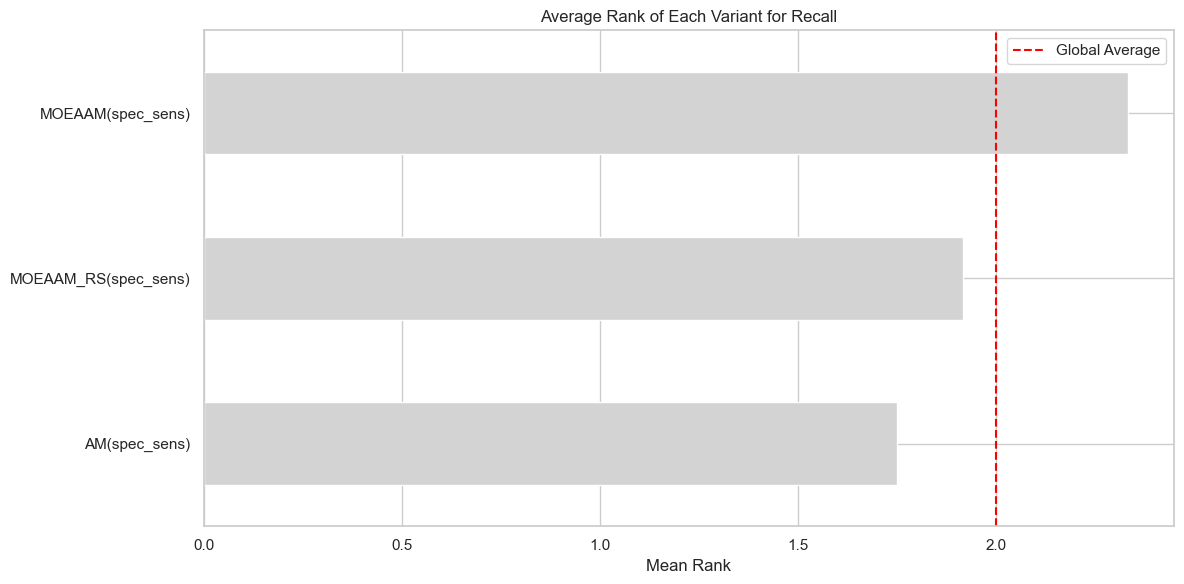

In [27]:
plot_avg_ranks(f1_avg_ranks, "Recall")

4. PRECISION

In [28]:
precision_dict = extract_means(dfs, target_metric="precision")

precision_df = pd.DataFrame(precision_dict, index=DATASETS)
precision_ranks, precision_avg_ranks = get_ranking(precision_df)
precision_ranks

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,97.66 (1),87.65 (2),86.09 (3)
tictactoe,75.66 (3),85.67 (1),76.54 (2)
hepatitis,50.28 (3),64.19 (1),59.46 (2)
ljubljana,58.18 (1),44.76 (2),41.74 (3)
cargood,45.65 (1),29.92 (3),31.41 (2)
chess,54.12 (3),54.82 (2),56.88 (1)
zoo3,0 (2),0 (2),0 (2)
flare,25.71 (1),18.5 (2),17.73 (3)
yeast3,41.42 (3),57.85 (1),53.69 (2)
segment0,78.92 (3),85.61 (2),85.94 (1)


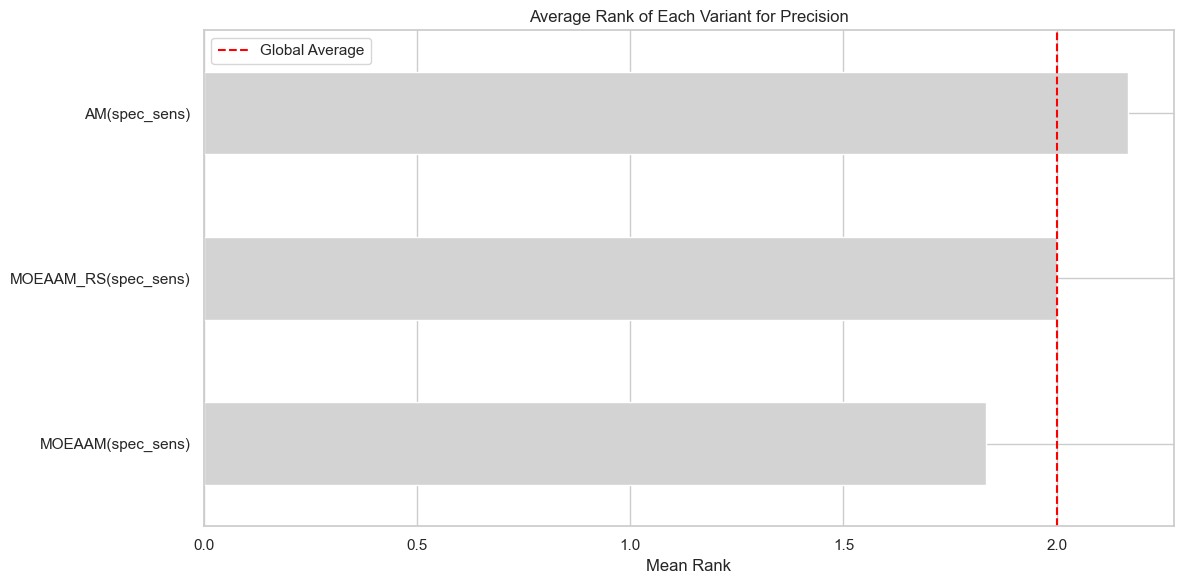

In [29]:
plot_avg_ranks(precision_avg_ranks, "Precision")

5. SPECIFICITY

In [30]:
specificity_dict = extract_means(dfs, target_metric="specificity")

specificity_df = pd.DataFrame(specificity_dict, index=DATASETS)
specificity_ranks, specificity_avg_ranks = get_ranking(specificity_df)
specificity_ranks

,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
mushrooms,97.58 (1),86.69 (2),84.62 (3)
tictactoe,47.63 (3),94.3 (1),66.1 (2)
hepatitis,88.66 (3),92.84 (1),90.24 (2)
ljubljana,88.97 (1),69.33 (2),65.87 (3)
cargood,97.89 (3),99.35 (1),98.88 (2)
chess,97.8 (1),97.78 (2),97.7 (3)
zoo3,99.37 (3),100 (1.5),100 (1.5)
flare,97.01 (3),99.63 (1),99.58 (2)
yeast3,96.9 (1),96.71 (2),96.49 (3)
segment0,96.01 (3),97.97 (1),97.61 (2)


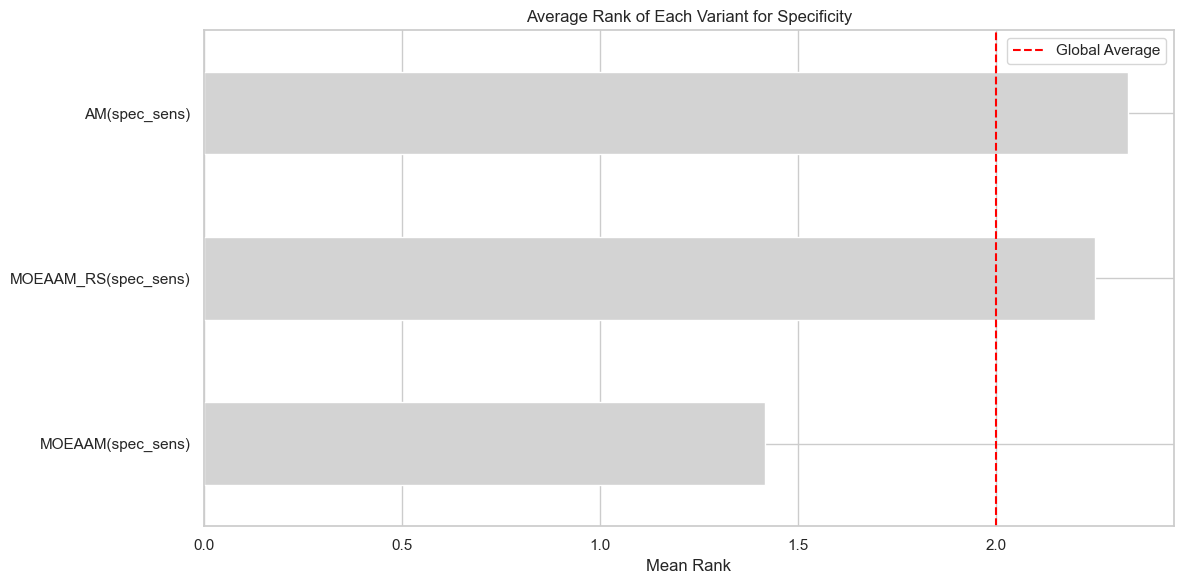

In [31]:
plot_avg_ranks(specificity_avg_ranks, "Specificity")

##### Friedman Tests

In [32]:
data = {
    "Accuracy": accuracy_dict,
    "F1 Score": f1_df,
    "Recall": recall_df,
    "Precision": precision_df,
    "Specificity": specificity_df
}

In [33]:
def friedman_test(data):
    results = []
    
    for metric, data in data.items():
        df = pd.DataFrame(data, index=DATASETS)
        
        stat, p_value = friedmanchisquare(*[df[col] for col in df.columns])
        
        results.append({
            "Metric": metric,
            "Chi-square Stat": stat,
            "P-value": p_value
        })
    
    return pd.DataFrame(results)

friedman_results = friedman_test(data)
friedman_results

,Metric,Chi-square Stat,P-value
0,Accuracy,0.000000,1.000000
1,F1 Score,2.600000,0.272532
2,Recall,3.800000,0.149569
3,Precision,0.800000,0.670320
4,Specificity,6.434783,0.040059


In [34]:
def wilcoxon_posthoc(df, p_threshold=0.05):

    algos = df.columns
    n = len(algos)
    p_matrix = pd.DataFrame(index=algos, columns=algos, dtype=float)
    
    print(f"{'='*10} Significant Pairs (p < {p_threshold}) {'='*10}")
    
    for i in range(n):
        for j in range(i + 1, n): 
            algo_a = algos[i]
            algo_b = algos[j]
            
            stat, p = wilcoxon(df[algo_a], df[algo_b], zero_method='zsplit')
            
            p_matrix.iloc[i, j], p_matrix.iloc[j, i] = p, p
            
            if p < p_threshold:
                print(f"{algo_a} and {algo_b}: p={p:.5f}")
    
    np.fill_diagonal(p_matrix.values, 1.0)
    return p_matrix

In [35]:
p_matrix = wilcoxon_posthoc(specificity_df)
p_matrix = p_matrix.map(lambda x: f"{x:.3f}")
p_matrix

========== Significant Pairs (p < 0.05) ==========
MOEAAM(spec_sens) and MOEAAM_RS(spec_sens): p=0.00195


,AM(spec_sens),MOEAAM(spec_sens),MOEAAM_RS(spec_sens)
AM(spec_sens),1.000,0.311,0.380
MOEAAM(spec_sens),0.311,1.000,0.002
MOEAAM_RS(spec_sens),0.380,0.002,1.000


##### Specific Friedman Tests

##### Classical Classification Algorithms

In [37]:
DATASETS_PATH = "../../datasets/SLC/"
def calculate_metrics(y_true, y_pred):

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape == (2, 2):

        tn, fp, _, _ = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return {
        "accuracy": acc * 100,
        "f1_score": f1 * 100,
        "recall": rec * 100,
        "precision": prec * 100,
        "specificity": spec * 100
    }

In [38]:
def get_baseline_results(datasets):
    baseline_data = []
    
    print(f"Running Training (RIPPER, C4.5, CS-C4.5)...")
    print("-" * 60)

    for ds in datasets:
        path = os.path.join(DATASETS_PATH, f"{ds}.csv")
        if not os.path.exists(path):
            path = path.replace(".csv", ".data")
        
        if not os.path.exists(path):
            continue

        try:
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip()
            if 'class' not in df.columns: continue
            
            y = LabelEncoder().fit_transform(df['class'])
            X = pd.get_dummies(df.drop('class', axis=1)).values
        except:
            continue

        n_folds = min(5, len(y))
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        algos = ["C4.5", "CS-C4.5", "RIPPER"]
        fold_results = {algo: {m: [] for m in ["accuracy", "f1_score", "recall", "precision", "specificity"]} for algo in algos}
        
        models = {
            "C4.5": DecisionTreeClassifier(criterion='entropy', random_state=42),
            "CS-C4.5": DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=42),
            "RIPPER": lw.RIPPER(random_state=42)
        }

        print(f"Running {ds}...")

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            for name, model in models.items():
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    metrics = calculate_metrics(y_test, y_pred)
                    
                    for m_name, m_val in metrics.items():
                        fold_results[name][m_name].append(m_val)
                except:
                    pass

        for name in algos:
            row = {"Dataset": ds, "Algorithm": name}
            for m in ["accuracy", "f1_score", "recall", "precision", "specificity"]:
                vals = fold_results[name][m]
                row[m] = np.mean(vals) if vals else 0.0
            
            baseline_data.append(row)

    return pd.DataFrame(baseline_data)

In [39]:
df_baselines = get_baseline_results(DATASETS)

Running Training (RIPPER, C4.5, CS-C4.5)...
------------------------------------------------------------
Running mushrooms...
Running tictactoe...
Running hepatitis...
Running ljubljana...
Running cargood...
Running chess...
Running zoo3...
Running flare...
Running yeast3...
Running segment0...
Running abalone19...
Running pageblocks...


In [40]:
df_baselines
#df_baselines.to_csv(os.path.join(SAVE_DIR, "baseline_results.csv"), index=False)

,Dataset,Algorithm,accuracy,f1_score,recall,precision,specificity
0,mushrooms,C4.5,100.000000,100.000000,100.000000,100.000000,100.000000
1,mushrooms,CS-C4.5,100.000000,100.000000,100.000000,100.000000,100.000000
2,mushrooms,RIPPER,100.000000,100.000000,100.000000,100.000000,100.000000
3,tictactoe,C4.5,93.636562,95.148319,95.372698,94.954080,90.370873
4,tictactoe,CS-C4.5,93.530214,95.011918,94.252698,95.797262,92.170963
5,tictactoe,RIPPER,98.954516,99.210069,99.682540,98.755809,97.575758
6,hepatitis,C4.5,72.903226,44.537815,53.809524,39.148629,78.066667
7,hepatitis,CS-C4.5,77.419355,45.807526,48.095238,44.825397,85.300000
8,hepatitis,RIPPER,80.645161,50.434343,44.285714,60.777778,90.100000
9,ljubljana,C4.5,64.680135,40.765300,41.838235,40.194828,74.345479


In [41]:
def compare_best(baseline_df, user_results_dict, datasets, metric="f1_score"):
    comparison_rows = []
    
    print(f"\n{'Dataset':<15} | {'Best Algo':<25} | {metric + ' %':<6}")
    print("-" * 80)
    
    for ds in datasets:

        ds_base = baseline_df[baseline_df['Dataset'] == ds]
        
        if not ds_base.empty:
            best_base_row = ds_base.loc[ds_base[metric].idxmax()]
            best_base_name = best_base_row['Algorithm']
            best_base_f1 = best_base_row[metric]
            best_base_acc = best_base_row['accuracy']
        else:
            best_base_name, best_base_f1, best_base_acc = "None", 0, 0

        best_user_name = "None"
        best_user_f1 = 0
        best_user_acc = 0
        
        if ds in user_results_dict and 'mean' in user_results_dict[ds]:
            df_user = user_results_dict[ds]['mean']
            if not df_user.empty:
                try:
                    test_df = df_user.xs('test', level='Split')
                    
                    if metric in test_df.columns:
                        idx_best = test_df[metric].idxmax()
                        
                        best_user_f1 = test_df.loc[idx_best, metric]
                        best_user_acc = test_df.loc[idx_best, 'accuracy']
                        best_user_name = f"{idx_best[0]} ({idx_best[1]})"
                except:
                    pass

        if best_user_f1 >= best_base_f1:
            winner = best_user_name
            win_f1 = best_user_f1
        else:
            winner = best_base_name
            win_f1 = best_base_f1
            
        print(f"{ds:<15} | {winner:<25} | {win_f1:.2f}")
        
        comparison_rows.append({
            "Dataset": ds,
            "Best_Algo": winner,
            metric: win_f1,
        })

    return pd.DataFrame(comparison_rows)

In [52]:
leaderboard = compare_best(df_baselines, dfs, DATASETS, metric="recall")


Dataset         | Best Algo                 | recall %
--------------------------------------------------------------------------------
mushrooms       | C4.5                      | 100.00
tictactoe       | RIPPER                    | 99.68
hepatitis       | C4.5                      | 53.81
ljubljana       | MOEAAM_RS (spec_sens)     | 57.43
cargood         | C4.5                      | 87.03
chess           | C4.5                      | 97.14
zoo3            | C4.5                      | 40.00
flare           | CS-C4.5                   | 27.78
yeast3          | C4.5                      | 70.72
segment0        | C4.5                      | 98.26
abalone19       | AM (spec_sens)            | 0.00
pageblocks      | CS-C4.5                   | 64.50
